In [835]:
import requests
import os
import pandas as pd
import json as json
import tweepy
import functools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tweepy import OAuthHandler
from timeit import default_timer as timer

### Gather

We initially need to gather three dataframes: the WeRateDogs Twitter archive (file on hand); a set of tweet image predictions of the breed of dog shown in tweets (available on a URL); and a df containing each tweet's retweet count and favorite ("like") count gathered from the Twitter API and converted from JSON.

In [836]:
# This programatically obtains the image predictions and reads in the archive.
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
open('./image-predictions.tsv', 'wb').write(r.content)
images_df = pd.read_csv('./image-predictions.tsv', sep='\t')
archive_df = pd.read_csv('./twitter-archive-enhanced.csv')

I have used the code available on the Project page for this; I filled out the developer request on Twitter's website 
but have not heard back after almost a week. I'm displaying this code in a markdown cell as it does not need to really run.

``` python
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = df_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
```

In [837]:
# Then reads the JSON.txt file containing the information queried from the Twitter API line by line to extract
# tweet_id, favorites, retweet count and timestamp. This code is based on an answer in Udacity Knowledge.

selected_attr = []

with open('tweet_json.txt') as json_file:
    for line in json_file:
        json_data = json.loads(line) 
        selected_attr.append({'tweet_id':json_data['id'],
                             'favorites': json_data['favorite_count'],
                             'retweets': json_data['retweet_count'],
                             'timestamp': json_data['created_at']})

# Instaniates the third dataframe, the four attributes extracted from the JSON data
attr_df = pd.DataFrame(selected_attr, columns=['tweet_id', 'favorites', 'retweets', 'timestamp'])

In [838]:
# Saves it to csv
attr_df.to_csv('attributes.csv')

In [839]:
# Check that it looks alright
attr_df.head()

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,39467,8853,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017


### Assess


In [840]:
images_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [841]:
# Examine the shape of the data
attr_df.tweet_id.is_unique, attr_df.shape

(True, (2354, 4))

In [842]:
images_df.tweet_id.is_unique, images_df.shape

(True, (2075, 12))

In [843]:
archive_df.tweet_id.is_unique, archive_df.shape

(True, (2356, 17))

In [844]:
# check for duplicated rows
sum(archive_df.tweet_id.duplicated()), sum(images_df.tweet_id.duplicated()), sum(attr_df.tweet_id.duplicated())

(0, 0, 0)

In [845]:
# look at the ratings to see if there are any problems
archive_df[['rating_numerator', 'rating_denominator']].sample(10)

,rating_numerator,rating_denominator
2142,10,10
1647,12,10
1612,10,10
1077,10,10
289,13,10
415,13,10
922,10,10
1858,13,10
1358,12,10
2004,12,10


In [846]:
# This checks to make sure the rating_numerator and rating_denominator columns don't have any really bad typos
sum(archive_df['rating_denominator'].astype('str').str.isnumeric()), archive_df.shape[0]

(2356, 2356)

In [847]:
# Checking for errors in archive_df -- there are several ratings that are not out of 10
archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [848]:
# Now the numerator
archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [849]:
# Visual inspection of some the tweets' urls in a browser shows that users sometimes rate out of multiples of 10
# if the images shows more than one dog, so 60/60 if there are 6 dogs, but in  most cases there is an error,
# e.g. 3 times 9/11 gets mistaken for a rating.

# This creates a list of the indices for rows where the denominator is other than 10
# prints out all the texts of tweets where the denominator is something other than 10
weird_denom_list = list(archive_df.loc[archive_df['rating_denominator'] != 10].index.values)
for w in weird_denom_list:
    print(archive_df.iloc[w]['text'], '\n Denominator:', archive_df.rating_denominator.iloc[w])

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 
 Denominator: 0
@docmisterio account started on 11/15/15 
 Denominator: 15
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 
 Denominator: 70
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 
 Denominator: 7
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 
 Denominator: 11
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 
 Denominator: 150
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 
 Denominator: 11
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://

In [850]:
# There are also several names that are not names, like "a"
A = archive_df.name.value_counts()
A

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Boston       1
Chuck        1
Edd          1
Andru        1
Tiger        1
Name: name, Length: 957, dtype: int64

In [851]:
# There are no NaNs for the values we're interested in
# The breed names in p1, p2 and p3 are objects
# We should consider making a categorical breed cateogry because its values are a finite set of options without order.
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Summary of issues to be cleaned
**Quality**
- `archive_df` has 2356 unique ids, `images_df` 2075 and `attr_df` 2354.
- There are retweets in the `archive_df` that need to be removed.
- `archive_df`: some dog names are incorrect, e.g. "a", "the" for "None"
- `archive_df`: some of the ratings are not out of 10
- `images_df`: some of the dogs are misidentified as other objects
- `tweet_id` is an `int` in all dfs
- `Timestamp` in `attr_df` is `object`.
- `Timestamp` in `archive_df` is `object`.
- `breed` in `images_df` should be categorical and capitalization of breeds made consistent
- `doggo`, `floofer`, `pupper`, `puppo` in `archive_df` should be Boolean instead of pandas objects

**Tidiness**
- `tweet_id` is duplicated across all three dfs and `timestamp` is duplicated across `attr_df` and `archive_df`
- each observational unit forms a table -- we need to put everything in one table
- `images_df` -- this could be both a tidiness issue or quality, but the most likely dog breed is distributed across several columns
- `images_df` -- the pictures of multiple dogs represent more than one observation per row, so we drop those

### Tidiness

#### <font color = blue> Completeness (Quality): `archive_df` has 2356 unique ids, `images_df` 2075 and `attr_df` 2354/ <br> Tidiness: each observational unit forms a table &mdash; we need to put everything in one table
 </font>

##### Define
*Use `pd.merge()` to join the three dataframes on `tweet_id`. Since there are three dataframes, I used the reduce() method from Python's functools library and a lambda function as suggested by someone on stackoverflow. This removes any tweets not common to all three dfs.*

##### Code

In [852]:
# Merge two of the dataframes, the default is an inner join so that will get rid of any rows that are not common
# to all three dfs
first_two = archive_df.merge(images_df, on='tweet_id')

In [853]:
# then another merge for the third df
final_df = attr_df.merge(first_two, on='tweet_id')

In [854]:
df_clean = final_df.copy()

##### Test

In [855]:
# We're down to 2073 rows
df_clean.shape

(2073, 31)

In [856]:
# And it looks good -- one unintended consequence is that we now have two 
df_clean

,tweet_id,favorites,retweets,timestamp_x,in_reply_to_status_id,in_reply_to_user_id,timestamp_y,source,text,retweeted_status_id,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,39467,8853,Tue Aug 01 16:23:56 +0000 2017,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068,666049248165822465,111,41,Mon Nov 16 00:24:50 +0000 2015,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
2069,666044226329800704,311,147,Mon Nov 16 00:04:52 +0000 2015,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
2070,666033412701032449,128,47,Sun Nov 15 23:21:54 +0000 2015,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
2071,666029285002620928,132,48,Sun Nov 15 23:05:30 +0000 2015,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,...,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


#### <font color = blue> `images_df`: the most likely dog breed is distributed across several columns and some columns have no dogs in any of `p1_dog`, `p2_dog`, `p3_dog` </font>
##### Define
Use a `for` loop to create a new column, `breed` that has the most probable breed value. Delete the rest.

##### Code

In [857]:
# A nested for loop iterates over first the rows and then (internal loop) each column

for row in range(0,df_clean.shape[0]):

    # There are three columns to check so the counter will let us know when we've finished three
    counter = 0
    breeds = ['p1_dog', 'p2_dog', 'p3_dog']

    for breed in breeds:
        counter +=1

        # First if-clause confirms dogs, creates column 'breed',
        # and populates it with current row and p_1, p_2 or p_3 column value
        if df_clean.at[row, breed] == True:
            df_clean.at[row, 'breed'] = df_clean.at[row, breed[:2]]
            break
        # Initially ignored, when counter reaches three because all three columns are False, 'breed' column reads 'no dog'
        elif counter == 3:
            df_clean.at[row, 'breed'] = "no dog"
        
        # if p1_dog etc column is false for this row, loop continues
        elif df_clean.at[row, breed ] == False:
            continue

In [858]:
nodog = df_clean[df_clean.breed == "no dog"]
df_clean = df_clean[df_clean.breed != "no dog"].copy()

In [859]:
# Get rid of the other columns related to breed identity
df_clean = df_clean.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1).reset_index(drop=True)

##### Test

In [860]:
# Check that the "no dog" catetories have been captured and removed
df_clean.breed.value_counts()

golden_retriever      173
Labrador_retriever    113
Pembroke               95
Chihuahua              95
pug                    65
                     ... 
clumber                 1
silky_terrier           1
Japanese_spaniel        1
Scotch_terrier          1
Irish_wolfhound         1
Name: breed, Length: 113, dtype: int64

In [861]:
df_clean

,tweet_id,favorites,retweets,timestamp_x,in_reply_to_status_id,in_reply_to_user_id,timestamp_y,source,text,retweeted_status_id,...,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,breed
0,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua
1,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua
2,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,...,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever
3,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,...,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset
4,891087950875897856,20562,3261,Sat Jul 29 00:08:17 +0000 2017,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,...,13,10,None,None,None,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745,666049248165822465,111,41,Mon Nov 16 00:24:50 +0000 2015,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,...,5,10,None,None,None,None,None,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher
1746,666044226329800704,311,147,Mon Nov 16 00:04:52 +0000 2015,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,...,6,10,a,None,None,None,None,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
1747,666033412701032449,128,47,Sun Nov 15 23:21:54 +0000 2015,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,...,9,10,a,None,None,None,None,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
1748,666029285002620928,132,48,Sun Nov 15 23:05:30 +0000 2015,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,...,7,10,a,None,None,None,None,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone


#### <font color = blue> `tweet_id` is duplicated across all three dfs and `timestamp` is duplicated across `attr_df` and `archive_df`
 </font>
 
##### Define
*`tweet_id` was removed by the merge above. Drop the duplicate `timestamp` columns and rename timestamp_x. While I'm at it I'm going to drop `in_reply_to_status_id`, `in_reply_to_user_id` and `source` since I won't use those in analysis and the df is a bit unwieldly*

##### Code

In [862]:
df_clean.drop(['in_reply_to_status_id', 'timestamp_y', 'in_reply_to_user_id', 'source'], axis=1, inplace = True)

In [863]:
df_clean[:2]

,tweet_id,favorites,retweets,timestamp_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,breed
0,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua
1,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua


In [864]:
df_clean.rename(columns={"timestamp_x": "timestamp"}, inplace=True)

##### Test

### Quality

#### <font color = blue> There are retweets in the `archive_df` that need to be removed. </font>
##### Define
*Filter the dataframe for retweets and delete them*

##### Code

In [865]:
# Because each retweet has a status_id and the rest (original tweets) are NaN, we can filter for that
# This makes a Boolean series of rows with NaN for retweeted_status, ie the NOT retweets
not_na = df_clean.retweeted_status_id.isnull()

In [866]:
# recast the dataframe using that Boolean series as index thus dropping the retweetes (the NOT NaNs)
df_clean = df_clean.iloc[not_na[not_na].index.tolist()].reset_index(drop=True)

In [867]:
# And get rid of the associated reweet columns now as well
df_clean = df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

##### Test

In [868]:
df_clean

,tweet_id,favorites,retweets,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,breed
0,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua
1,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua
2,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever
3,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset
4,891087950875897856,20562,3261,Sat Jul 29 00:08:17 +0000 2017,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,666049248165822465,111,41,Mon Nov 16 00:24:50 +0000 2015,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher
1682,666044226329800704,311,147,Mon Nov 16 00:04:52 +0000 2015,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
1683,666033412701032449,128,47,Sun Nov 15 23:21:54 +0000 2015,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
1684,666029285002620928,132,48,Sun Nov 15 23:05:30 +0000 2015,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone


#### <font color = blue> Some dog `name`s are incorrect, e.g. "a", "the" for "None" </font>
##### Define
*Since the incorrect names are all lowercase, we can use islower() to find them and change them to None*

##### Code

In [869]:
# Here we will isolate a list of not-names
# This is a dataframe of all the names, created with value_counts()
notaname = pd.DataFrame(df_clean.name.value_counts())

# The index labels that result are the names, we want them in a column
notaname.reset_index(level=0, inplace=True)
notaname.columns = ['name', 'count']

# and then call islower() to make a list of words from the 'name' column that aren't names
not_names = [c for c in df_clean.name if c.islower()]

In [870]:
# In most cases visual inspection shows that the not_names values usually represent tweets where the text contains
# no name, and the use of regex (mapping on to "This is a") resulted in an erroneanous name (e.g. reading "a" as
# the name in "This is a husky" because the regex set to filter things like "This is Max," which is the format in most
# tweets). So we'll just set the rows with not_names as "None"   

# Replace any value from not_names list with 'None' and assign to df_clean.name
df_clean.name = df_clean.name.replace(not_names, 'None')

##### Test

In [871]:
# We can see that none of these are names
set(not_names)

{'a',
 'actually',
 'all',
 'an',
 'getting',
 'incredibly',
 'infuriating',
 'just',
 'light',
 'my',
 'not',
 'officially',
 'one',
 'quite',
 'space',
 'the',
 'unacceptable',
 'very'}

In [872]:
# tests that all the not-names have been removed
sum(df_clean.name.str.islower())

0

#### <font color = blue> Some of the `rating_denominator`s are not out of 10 </font>
##### Define
*Drop the denominators that are not 10*

##### Code

In [873]:
# We need to redefine the list with the new df
weird_denom_list = list(df_clean.loc[df_clean['rating_denominator'] != 10].index.values)

In [874]:
df_clean = df_clean.drop(weird_denom_list, axis=0).reset_index(drop=True)

##### Test

In [875]:
# This is the same code as weird_denom_list, it's now empty
test_list = list(df_clean.loc[df_clean['rating_denominator'] != 10].index.values)
test_list

[]

In [876]:
# Now that we've eliminated weird denominators, let's see if there are any weird numerators left:
df_clean.rating_numerator.value_counts()

12    423
10    360
11    356
13    229
9     132
8      68
7      31
14     23
6      16
5      14
4       6
3       5
2       2
75      1
27      1
26      1
0       1
Name: rating_numerator, dtype: int64

In [877]:
# Let's look at the ones that are less than 5 or greather than 15 and make sure those are correct
weird_numer_list = list(df_clean.loc[(df_clean['rating_numerator'] > 15) | (df_clean['rating_numerator'] < 5)].index.values)
weird_numer_list

[208,
 452,
 497,
 498,
 665,
 807,
 847,
 888,
 1181,
 1189,
 1227,
 1361,
 1455,
 1537,
 1584,
 1614,
 1636]

In [878]:
# We see a couple of places where incorrect values were extracted -- 9.75 becomes 75, 11.27 becomes 27, 11.26 becomes
# 26
for w in weird_numer_list:
    print(df_clean.iloc[w]['text'], '\n Numerator:', df_clean.rating_numerator.iloc[w])
    print("index is", w)

When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag 
 Numerator: 0
index is 208
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 
 Numerator: 75
index is 452
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq 
 Numerator: 27
index is 497
This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M 
 Numerator: 3
index is 498
Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R 
 Numerator: 4
index is 665
This is Alexanderson. He's got a weird ass birth mark. Dreadful at fetch. Won't eat kibble. 3/10 wtf @Target https://t.co/FmxOpf2Sgl 
 Numerator: 3
index is 807
What hooliga

In [879]:
# I'll fix that by hand, first the numerator column needs to be a float

In [880]:
df_clean.rating_numerator = df_clean.rating_numerator.astype('float64')

In [881]:
# 452 -> 9.75
# 497 -> 11.27
# 1189 -> 11.26
df_clean.at[452, 'rating_numerator'] = 9.75
df_clean.at[497, 'rating_numerator'] = 11.27
df_clean.at[1189, 'rating_numerator'] = 11.26

In [882]:
# test
df_clean.at[452, 'rating_numerator'], df_clean.at[497, 'rating_numerator'], df_clean.at[1189, 'rating_numerator']

(9.75, 11.27, 11.26)

#### <font color = blue> `tweet_id` is an `int` </font>
##### Define
*Cast the column to object using `astype()`*

##### Code

In [883]:
df_clean.tweet_id = df_clean.tweet_id.astype('object')

In [884]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1669 non-null   object 
 1   favorites           1669 non-null   int64  
 2   retweets            1669 non-null   int64  
 3   timestamp           1669 non-null   object 
 4   text                1669 non-null   object 
 5   expanded_urls       1669 non-null   object 
 6   rating_numerator    1669 non-null   float64
 7   rating_denominator  1669 non-null   int64  
 8   name                1669 non-null   object 
 9   doggo               1669 non-null   object 
 10  floofer             1669 non-null   object 
 11  pupper              1669 non-null   object 
 12  puppo               1669 non-null   object 
 13  jpg_url             1669 non-null   object 
 14  img_num             1669 non-null   int64  
 15  breed               1669 non-null   object 
dtypes: flo

##### Test

#### <font color = blue> `timestamp` is a pandas object </font>
##### Define
*Cast `timestamp` as `datetime64` using `astype()`*

##### Code

In [885]:
df_clean.timestamp = df_clean.timestamp.astype('datetime64')

##### Test

In [886]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1669 non-null   object        
 1   favorites           1669 non-null   int64         
 2   retweets            1669 non-null   int64         
 3   timestamp           1669 non-null   datetime64[ns]
 4   text                1669 non-null   object        
 5   expanded_urls       1669 non-null   object        
 6   rating_numerator    1669 non-null   float64       
 7   rating_denominator  1669 non-null   int64         
 8   name                1669 non-null   object        
 9   doggo               1669 non-null   object        
 10  floofer             1669 non-null   object        
 11  pupper              1669 non-null   object        
 12  puppo               1669 non-null   object        
 13  jpg_url             1669 non-null   object      

#### <font color = blue> `breed` should be categorical and capitalization made consistent </font>
##### Define
*Cast breed as `category` using `astype()` and fix the names with `str.capitalize()`*

##### Code

In [887]:
df_clean.breed = df_clean.breed.astype('category')

In [888]:
df_clean.breed = df_clean.breed.str.capitalize()

##### Test

In [889]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1669 non-null   object        
 1   favorites           1669 non-null   int64         
 2   retweets            1669 non-null   int64         
 3   timestamp           1669 non-null   datetime64[ns]
 4   text                1669 non-null   object        
 5   expanded_urls       1669 non-null   object        
 6   rating_numerator    1669 non-null   float64       
 7   rating_denominator  1669 non-null   int64         
 8   name                1669 non-null   object        
 9   doggo               1669 non-null   object        
 10  floofer             1669 non-null   object        
 11  pupper              1669 non-null   object        
 12  puppo               1669 non-null   object        
 13  jpg_url             1669 non-null   object      

In [890]:
sum(df_clean.breed.str.islower())

0

#### <font color = blue> `doggo`, `floofer`, `pupper`, `puppo` should be Booleans instead of pandas objects </font>
##### Define
*Assign the columns to equivalent Boolean series*

##### Code

In [891]:
# First we can see how many doggos, for example there are
sum(df_clean.doggo == 'doggo')

64

In [892]:
df_clean.doggo = (df_clean.doggo == 'doggo')
df_clean.floofer = (df_clean.floofer == 'floofer')
df_clean.pupper = (df_clean.pupper == 'pupper')
df_clean.puppo = (df_clean.puppo == 'puppo')

##### Test

In [893]:
# We can now count 64 doggos with the Boolean series
sum(df_clean.doggo)

64

In [894]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1669 non-null   object        
 1   favorites           1669 non-null   int64         
 2   retweets            1669 non-null   int64         
 3   timestamp           1669 non-null   datetime64[ns]
 4   text                1669 non-null   object        
 5   expanded_urls       1669 non-null   object        
 6   rating_numerator    1669 non-null   float64       
 7   rating_denominator  1669 non-null   int64         
 8   name                1669 non-null   object        
 9   doggo               1669 non-null   bool          
 10  floofer             1669 non-null   bool          
 11  pupper              1669 non-null   bool          
 12  puppo               1669 non-null   bool          
 13  jpg_url             1669 non-null   object      

In [895]:
# All clean!
df_clean

,tweet_id,favorites,retweets,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,breed
0,892177421306343426,33819,6514,2017-08-01 00:17:27,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,False,False,False,False,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua
1,891815181378084864,25461,4328,2017-07-31 00:18:03,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,False,False,False,False,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua
2,891689557279858688,42908,8964,2017-07-30 15:58:51,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,False,False,False,False,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever
3,891327558926688256,41048,9774,2017-07-29 16:00:24,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,False,False,False,False,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset
4,891087950875897856,20562,3261,2017-07-29 00:08:17,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,False,False,False,False,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_bay_retriever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,666049248165822465,111,41,2015-11-16 00:24:50,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,None,False,False,False,False,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher
1665,666044226329800704,311,147,2015-11-16 00:04:52,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,None,False,False,False,False,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
1666,666033412701032449,128,47,2015-11-15 23:21:54,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,None,False,False,False,False,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
1667,666029285002620928,132,48,2015-11-15 23:05:30,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,None,False,False,False,False,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone


In [896]:
df_clean.to_csv('WeRateDogs_clean.csv', index=False)

### Analysis and Visualizations

For this I will ask four questions of the data:
- Is there any shift over time in number of tweets &mdash; is WeRateDogs getting more or less popular in this time?
- What are the most common breeds? How are they rated &mdash; do certain breeds fare better in the rating system?
- Do tweets with higher ratings get retweeted or marked as favorites more often?
- What are the most common dog names? Are certain names associated with higher ratings?

The first preliminary question I had was: what is the most retweeted or most favorited tweet/dog. That is easy to find out:

In [897]:
df_clean.loc[df_clean['favorites'].idxmax()], df_clean.loc[df_clean['retweets'].idxmax()]

(tweet_id                                             822872901745569793
 favorites                                                        132810
 retweets                                                          48265
 timestamp                                           2017-01-21 18:26:02
 text                  Here's a super supportive puppo participating ...
 expanded_urls         https://twitter.com/dog_rates/status/822872901...
 rating_numerator                                                     13
 rating_denominator                                                   10
 name                                                               None
 doggo                                                             False
 floofer                                                           False
 pupper                                                            False
 puppo                                                              True
 jpg_url                 https://pbs.twimg.com/medi

#### Is there any shift over time in number of tweets &mdash; is WeRateDogs getting more or less popular in this time?

The code below creates a dataframe grouped by week using `resample()` to look the number of tweets per week and the number of retweets per week, visualized in two graphs. As we can see, by the metric of number of unqiue tweets, it appears that WeRateDogs experienced a spike in popularity just after it was created in November 2015. However, by the metric of number of retweets, although there is a spike at the beginning, the number of retweets is more level. Fitting a quick linear regression shows it is quite likely the number of retweets is increasing slightly with time.

In [898]:
df_clean.index = df_clean.timestamp

In [899]:
by_week = df_clean.resample('W').tweet_id.count().to_frame()

In [900]:
by_week['retweets'] = df_clean.resample('W').retweets.sum()

In [901]:
by_week['week'] = by_week.index

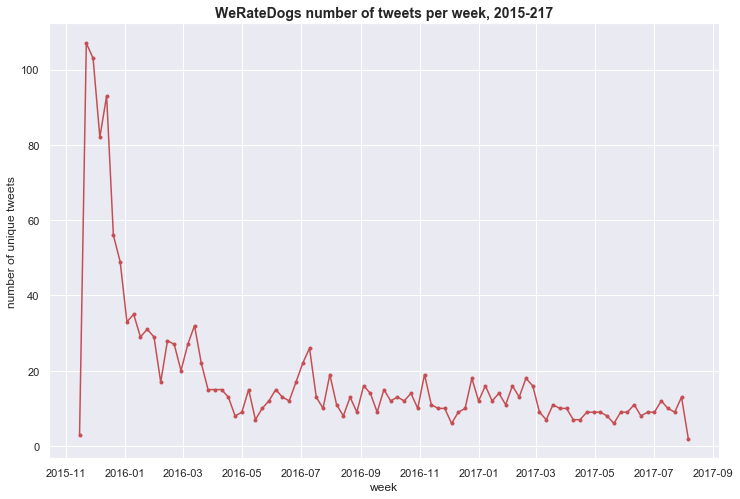

In [902]:
sns.set()
plt.subplots(figsize=(12, 8))
plt.plot(by_week['week'], by_week['tweet_id'], 'r.-')
plt.title('WeRateDogs number of tweets per week, 2015-217',  fontsize=14, fontweight='bold')
plt.xlabel('week')
plt.ylabel('number of unique tweets');

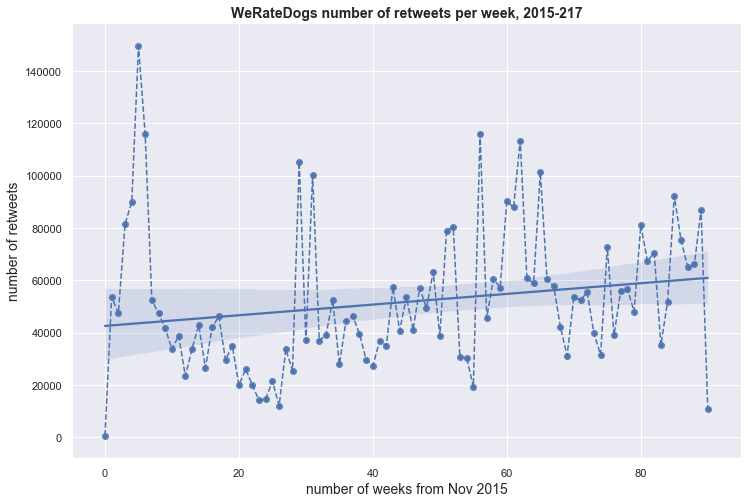

In [903]:
sns.set()
by_week['no_weeks'] = np.arange(len(by_week))
plt.subplots(figsize=(12, 8))
plt.plot(by_week['no_weeks'], by_week['retweets'], 'b.--')
plt.title('WeRateDogs number of retweets per week, 2015-217', fontsize=14, fontweight='bold')
sns.regplot(x="no_weeks", y="retweets", data=by_week)
plt.xlabel('number of weeks from Nov 2015', fontsize=14)
plt.ylabel('number of retweets', fontsize=14);

#### What are the most common breeds?

For this answer, first we can just do a value count of breeds; this is visualized in the first bar chart below, "WeRateDogs number of images by breed". The chart displays the top 30 out of 113 breeds identified by the algorithm. Given the low accuracy of some of the predictions, these need to be taken with a grain of salt, but the overall picture for the top dogs is clean. The top 5 are:

In [904]:
df_clean['breed'].value_counts()[:5]

Golden_retriever      154
Labrador_retriever    105
Pembroke               95
Chihuahua              90
Pug                    62
Name: breed, dtype: int64

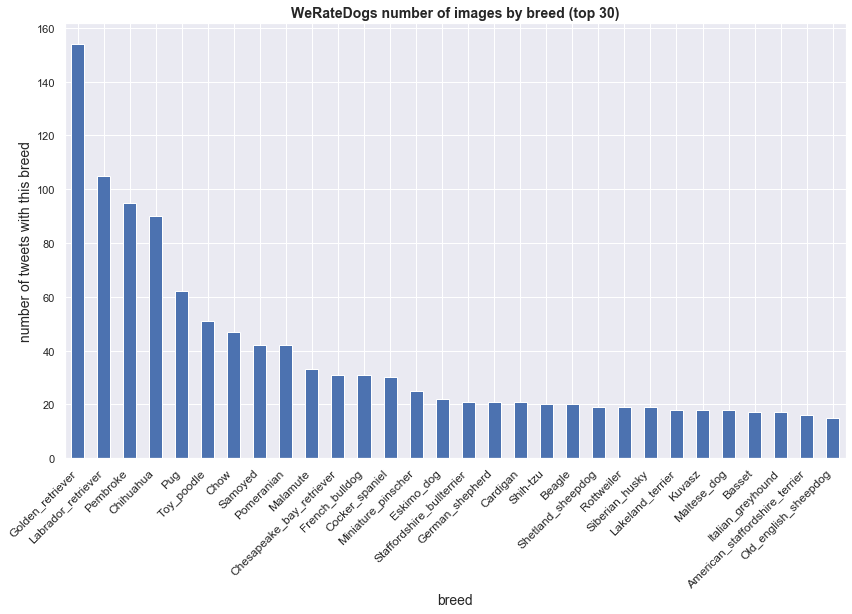

In [905]:
df_clean['breed'].value_counts()[:30].plot(kind='bar', figsize=(14,8))
plt.title("WeRateDogs number of images by breed (top 30)", fontsize=14, fontweight='bold')
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.ylabel('number of tweets with this breed', fontsize=14)
plt.xlabel('breed', fontsize=14);


####  How are they rated &mdash; do certain breeds fare better in the rating system?

While the most common dogs in the American pet inventory (golden retrievers and labradors in particular &mdash; lists of the most common breeds are available [here](https://www.akc.org/most-popular-breeds/)) are well represented in WeRateDog's tweets, the breeds that receive the highest ratings are more exotic. Here are the top ten highest ranked, and the visualizalion below shows the top 30.

In [906]:
rank_by_breed = df_clean.groupby(['breed'])['rating_numerator'].mean().sort_values(ascending=False).to_frame()
rank_by_breed[:10]

,rating_numerator
breed,
Bouvier_des_flandres,13.000000
Saluki,12.500000
Briard,12.333333
Tibetan_mastiff,12.250000
Border_terrier,12.142857
Standard_schnauzer,12.000000
Silky_terrier,12.000000
Irish_setter,11.750000
Gordon_setter,11.750000


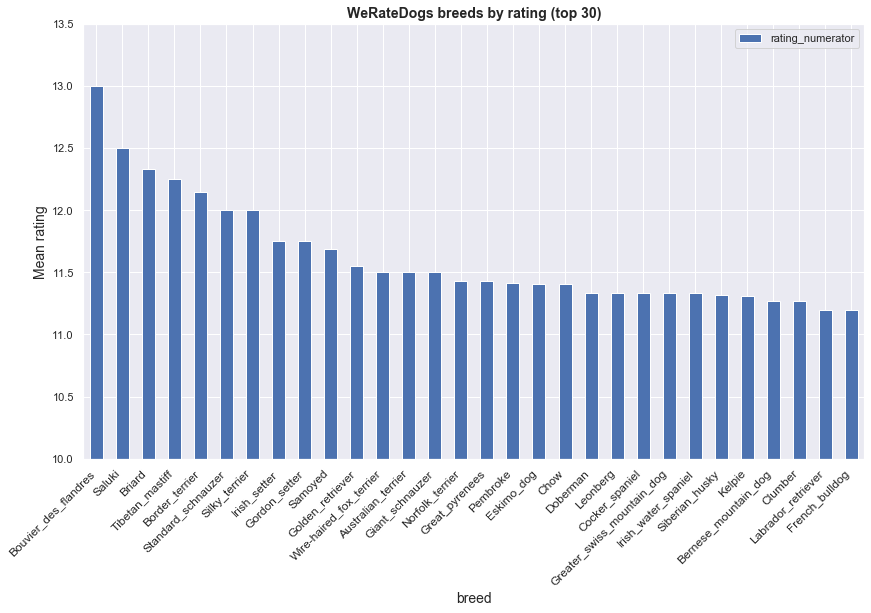

In [907]:
rank_by_breed[:30].plot(kind='bar', figsize=(14,8), ylim=(10,13.5))
plt.title('WeRateDogs breeds by rating (top 30)', fontsize=14, fontweight='bold')
plt.ylabel('Mean rating', fontsize=14)
plt.xlabel('breed', fontsize=14)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);


#### Do tweets with higher ratings get retweeted or marked as favorites more often?


The short answer to this is yes, as is very clearly demonstrated in the graph below. However, in order to produce a useful number we have to divide the number of retweets by the number of original tweets. It is imporant to note, as we can see in the by_rating dataframe below, that very few people give ratings of 9, 12, or 13. In particular, if we disregard the 9, the trends towards more retweets of higher-rated dogs is very clear.

In [908]:
by_rating = df_clean.groupby('rating_numerator', as_index=False)['retweets'].sum()

In [909]:
by_rating['tweet_id'] = df_clean.groupby('rating_numerator', as_index=False)['tweet_id'].count()['tweet_id']

In [910]:
by_rating['proportion'] = by_rating.retweets / by_rating.tweet_id

In [911]:
by_rating

,rating_numerator,retweets,tweet_id,proportion
0,0.00,3443,1,3443.000000
1,2.00,3007,2,1503.500000
2,3.00,5432,5,1086.400000
3,4.00,7185,6,1197.500000
4,5.00,21269,14,1519.214286
5,6.00,18856,16,1178.500000
6,7.00,27267,31,879.580645
7,8.00,53573,68,787.838235
8,9.00,112224,132,850.181818
9,9.75,7069,1,7069.000000


Text(0, 0.5, 'number of retweets')

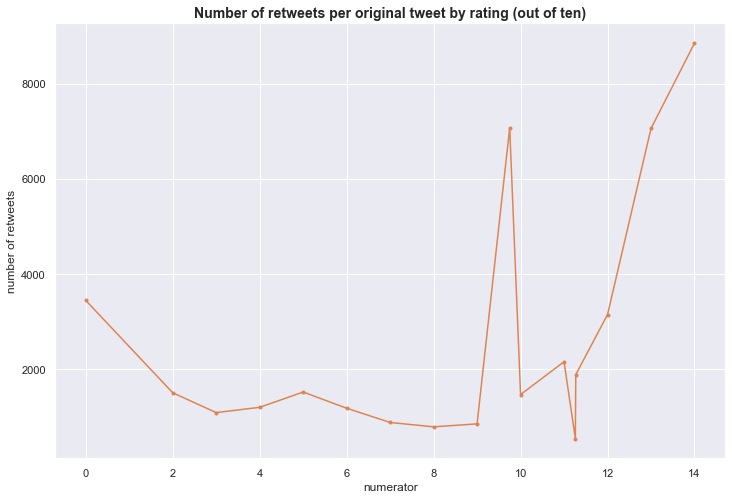

In [912]:
sns.set()
plt.subplots(figsize=(12, 8))
plt.plot(by_rating['rating_numerator'], by_rating['proportion'], 'C1.-')
plt.title('Number of retweets per original tweet by rating (out of ten)',  fontsize=14, fontweight='bold')
plt.xlabel('numerator')
plt.ylabel('number of retweets')

#### What are the most common dog names? Are certain names associated with higher ratings?

The answering the first question is trivial, and the table below show the twenty most popular dog names. With regard to ratings, a query of the top ten names show that they are all *hapax legomena*, so there is insufficient data to answer the second question. It seems unlikely looking at the shape of the data that there is any correlation.

In [913]:
df_clean.name.value_counts()[:20]

None       485
Cooper      10
Lucy        10
Charlie     10
Tucker       9
Oliver       9
Penny        8
Daisy        7
Sadie        7
Winston      7
Toby         6
Koda         6
Lola         6
Jax          6
Stanley      5
Leo          5
Rusty        5
Bella        5
Bo           5
Oscar        5
Name: name, dtype: int64

In [914]:
by_name = df_clean.groupby(['name'])['rating_numerator'].mean().sort_values(ascending=False).to_frame()
by_name[:10]

,rating_numerator
name,
Smiley,14.0
Ollie,14.0
Sundance,14.0
Cermet,14.0
Emmy,14.0
Doobert,14.0
Kuyu,14.0
Zooey,13.0
Bronte,13.0


In [915]:
df_clean.query('name == "Bruno"')

,tweet_id,favorites,retweets,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,breed
timestamp,,,,,,,,,,,,,,,,
2017-07-25 16:11:53,889880896479866881,28268,5156,2017-07-25 16:11:53,This is Bruno. He is a service shark. Only get...,https://twitter.com/dog_rates/status/889880896...,13.0,10,Bruno,False,False,False,False,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog
